# Uloha 5 - Neuronove site

## Nacteni a rozdeleni datasetu

In [6]:
from tensorflow.keras.datasets import mnist

(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

print("Full training dataset:", x_train_full.shape)
print("Test dataset:", x_test.shape)


Full training dataset: (60000, 28, 28)
Test dataset: (10000, 28, 28)


In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

print("Training dataset:", x_train.shape)
print("Validation dataset:", x_val.shape)


Training dataset: (48000, 28, 28)
Validation dataset: (12000, 28, 28)


### Proc jsem zvolila tento pomer?
- Data uz byla rozdelena na trenovaci a testovaci dataset, kdyz jsem je nacetla, pomer byl 6:1, coz jsem tak nechala.
- Trenovaci dataset jsem nadale rozdelila na trenovaci a validacni, zvolila jsem pomer 5:1 (`test_size=0.2`), protoze je tam dostatek dat pro trenink, ale zaroven i dost dat pro sledovani presnosti

## Zobrazeni trenovaciho datasetu a velikosti jednotlivych kategorii

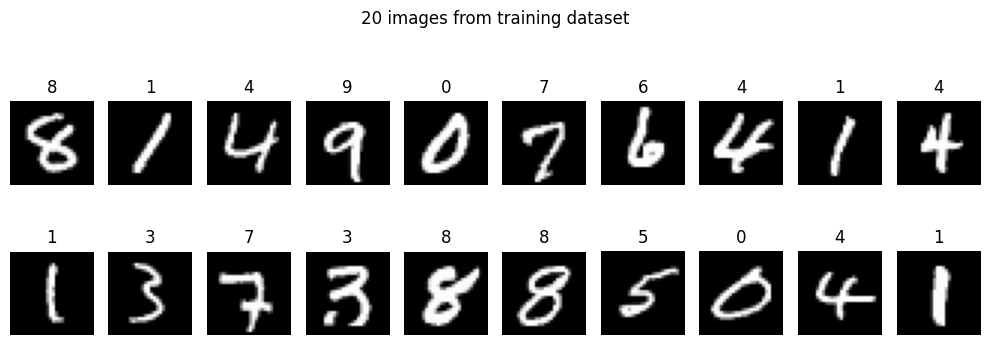

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 4))
for i in range(20):
    idx = np.random.randint(0, len(x_train))
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.axis('off')
    plt.title(y_train[idx])
plt.suptitle("20 images from training dataset")
plt.tight_layout()
plt.show()


In [9]:
import collections

counter = collections.Counter(y_train)
for label in sorted(counter):
    print(f"Number {label}: {counter[label]} images")


Number 0: 4748 images
Number 1: 5420 images
Number 2: 4784 images
Number 3: 4912 images
Number 4: 4666 images
Number 5: 4317 images
Number 6: 4741 images
Number 7: 4966 images
Number 8: 4691 images
Number 9: 4755 images


### Proc ma vliv, jestli je dataset vybalancovany?
- Sit se nauci vice zastoupenou tridu lepe a zaroven se nauci, ze je pravdepodobnejsi tato trida (pokud nahodne zvoli tuto tridu, bude mit vyssi pravdepodobnost, ze se trefi), tudiz ji bude preferovat i behem predikce.
- Naopak mene zastoupenou tridu se nauci mene a behem predikce je vetsi sance, ze misto teto tridy, zvoli jinou, spatnou.

In [10]:
print("Image size:", x_train[0].shape)


Image size: (28, 28)


## Vytvoreni architektury neuronove site

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.summary()


/home/monika/miniconda3/envs/asii-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-15 00:10:18.862485: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

### Proc jsem se rozhodla sit navrhnout takto?
- Prvni konvolucni vrstva: konvolucni vrstva s malymi filtry, ktere detekuji zakladni rysy - hrany a rohy, 32 filtru je standard a 28x28 je velikost vstupnich obrazku.
- Max pooling vrstva: snizuje velikosti obrazku pomoci max pooling (vybere z kazde casti vzdy pixel s nejvyssi hodnotou).
- Druha konvolucni vrstva: konvulucni vrstva s vice filtry, detekuje slozitejsi vzory, take diky tomu, ze je obrazek zjednoduseny pooling vrstvou.
- Max pooling vrstva: opet zmensuje obrazek, takze se sit muze soustredit na hlavni rysy.
- Flatten vrstva: prevede dvourozmerny obrazek na jednorozmerny vektor.
- Dense vrstva: plne propojena vrstva, ktera spojuje konvolucni vrstvy s klasifikacnimi - kombinuje naucene rysy. Pouziva aktivacni funkci relu, coz je 0 pro zaporne hodnoty a stejna hodnota pro kladne hodnoty, to zajisti nelinearitu.
- Dropout vrstva: nahodne vypina 50 % neuronu behem treninku, cimz zajistuje, aby se sit nepreucila.
- Dense: vystupni vrstva, ktera vraci pravdepodobnosti jednotlivych trid, pouziva na to aktivacni funkci softmax, ktera prevede vystupy na pravdepodobnosti, ma 10 neuronu, coz je jeden pro kazdou kategorii (cislici).

## Natrenovani neuronove site

In [12]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
# normalize inputs
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# add 4th dimension
x_train = x_train[..., np.newaxis]
x_val = x_val[..., np.newaxis]
x_test = x_test[..., np.newaxis]

# train
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, y_val)
)


Epoch 1/10


2025-05-15 00:10:26.323763: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7748 - loss: 0.7106 - val_accuracy: 0.9758 - val_loss: 0.0822
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9516 - loss: 0.1650 - val_accuracy: 0.9816 - val_loss: 0.0594
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9634 - loss: 0.1229 - val_accuracy: 0.9842 - val_loss: 0.0515
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9707 - loss: 0.0984 - val_accuracy: 0.9851 - val_loss: 0.0532
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9750 - loss: 0.0809 - val_accuracy: 0.9880 - val_loss: 0.0435
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9792 - loss: 0.0675 - val_accuracy: 0.9884 - val_loss: 0.0398
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9816 - loss: 0.0603 - val_accuracy: 0.9880 - val_loss: 0.0413
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9830 - loss: 0.0529 - val_accuracy: 0.989

### Proc jsem zvolila tyto parametry:
- Pocet epoch: zvolila jsem 10, aby trenink netrval dlouho, hlavne pro prvotni overeni, ze sit neni preucena atd, pri optimalizaci se da navysit.
- Batch size: zvolila jsem 64, coz je bezna hodnota jako kompromis mezi narocnosti na pamet (pri vyssim batch size) a rychlosti trenovani. Mensi batch size ma taky vetsi sum pri treniniku, coz muze byt fajn proti preuceni, ale zase tam vice kolisa loss a accuracy krivka. Sice jsem dostala warning, ze se pouziva vice nez 10 % pameti, ale fungovalo to.
- Optimalizacni algoritmus: vyuziva se Adam, ktery je defaultni a mel by dobre fungovat na vetsinu uloh, i treba pro mensi datasety atd.
- Loss funkce: je pouzita `sparse_categorical_crossentropy`, protoze je vhodna pro multiclass klasifikaci a pro kategorie, kdy ma kazda kategirie index (v nasem pripade 0-9) a ne one-hot encoded vektor.
- Metrika: Byla zvolena accuracy, coz sleduje, jak velke procento bylo zarazeno spravne. Je to zakladni metrika pro klasifikaci.

## Testovani neuronove site

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9893 - loss: 0.0340
Test accuracy: 0.9907


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


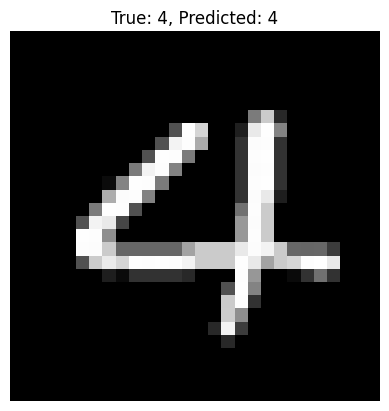

In [15]:
import matplotlib.pyplot as plt

i = np.random.randint(len(x_test))
img = x_test[i]
label = y_test[i]
pred = model.predict(img[np.newaxis, ...])
predicted_label = np.argmax(pred)

plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"True: {label}, Predicted: {predicted_label}")
plt.axis('off')
plt.show()


### Testovani site
- Model ma presnost na testovacim datasetu 99.07 %, coz je pomerne dobre, presnost by se dala jeste dale zvysovat opmtimalizaci parametru.
- Nahodne byla zvolena cislice 4 a byla spravne predikovana.

## Optimalizace parametru

### Pocet epoch

In [16]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_val, y_val)
)

Epoch 1/5


2025-05-15 00:13:45.413205: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9861 - loss: 0.0436 - val_accuracy: 0.9895 - val_loss: 0.0416
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9877 - loss: 0.0373 - val_accuracy: 0.9892 - val_loss: 0.0414
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9894 - loss: 0.0344 - val_accuracy: 0.9908 - val_loss: 0.0424
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9880 - loss: 0.0351 - val_accuracy: 0.9903 - val_loss: 0.0388
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9899 - loss: 0.0302 - val_accuracy: 0.9918 - val_loss: 0.0384


In [17]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9895 - loss: 0.0403
Test accuracy: 0.9917


In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=64,
    validation_data=(x_val, y_val)
)

Epoch 1/2


2025-05-15 00:22:43.343901: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9908 - loss: 0.0269 - val_accuracy: 0.9906 - val_loss: 0.0384
Epoch 2/2
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9908 - loss: 0.0292 - val_accuracy: 0.9900 - val_loss: 0.0464


In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9916 - loss: 0.0354
Test accuracy: 0.9924


In [20]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(x_val, y_val)
)

Epoch 1/15


2025-05-15 00:23:53.002962: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9915 - loss: 0.0267 - val_accuracy: 0.9912 - val_loss: 0.0373
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9917 - loss: 0.0262 - val_accuracy: 0.9907 - val_loss: 0.0454
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9924 - loss: 0.0227 - val_accuracy: 0.9903 - val_loss: 0.0523
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9918 - loss: 0.0242 - val_accuracy: 0.9912 - val_loss: 0.0457
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9932 - loss: 0.0212 - val_accuracy: 0.9907 - val_loss: 0.0392
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9925 - loss: 0.0210 - val_accuracy: 0.9907 - val_loss: 0.0499
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9934 - loss: 0.0190 - val_accuracy: 0.9910 - val_loss: 0.0447
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9936 - loss: 0.0201 - val_accuracy: 0.991

In [21]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9910 - loss: 0.0489
Test accuracy: 0.9922


### Pocet epoch
- Zda se, ze pocet epoch nema na accuracy zasadni vliv, nezda se, ze by se presnosti lisily, lisit se trochu muzou i kvuli nahodne slozce.
- Tudiz je podle pravidla occamovy britvy lepsi zvolit nizsi pocet epoch, zkousela jsem i pouze 2 epochy a presnost se nijak nezhorsila.

### Batch size

In [22]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=32,
    validation_data=(x_val, y_val)
)

Epoch 1/2


2025-05-15 00:30:06.277182: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9937 - loss: 0.0190 - val_accuracy: 0.9896 - val_loss: 0.0583
Epoch 2/2
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9934 - loss: 0.0200 - val_accuracy: 0.9916 - val_loss: 0.0399


In [23]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9900 - loss: 0.0452
Test accuracy: 0.9922


In [24]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=16,
    validation_data=(x_val, y_val)
)

Epoch 1/2
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9916 - loss: 0.0271 - val_accuracy: 0.9894 - val_loss: 0.0466
Epoch 2/2
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9901 - loss: 0.0286 - val_accuracy: 0.9895 - val_loss: 0.0543


In [25]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9897 - loss: 0.0436
Test accuracy: 0.9910


In [26]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9940 - loss: 0.0192 - val_accuracy: 0.9907 - val_loss: 0.0507
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9959 - loss: 0.0130 - val_accuracy: 0.9913 - val_loss: 0.0489


In [27]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9903 - loss: 0.0515
Test accuracy: 0.9926


### Batch size
- Zda se ze ani bach size nema vliv na presnost modelu, tudiz bych zvolila posledni moznost (128), protoze se ucil rychleji.

### Learning rate

In [28]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9955 - loss: 0.0131 - val_accuracy: 0.9912 - val_loss: 0.0507
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9960 - loss: 0.0116 - val_accuracy: 0.9917 - val_loss: 0.0547


In [29]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9915 - loss: 0.0521
Test accuracy: 0.9930


In [30]:
optimizer = Adam(learning_rate=0.005)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9871 - loss: 0.0450 - val_accuracy: 0.9907 - val_loss: 0.0418
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9864 - loss: 0.0404 - val_accuracy: 0.9887 - val_loss: 0.0491


In [31]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9865 - loss: 0.0516
Test accuracy: 0.9891


In [32]:
optimizer = Adam(learning_rate=0.0005)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9912 - loss: 0.0271 - val_accuracy: 0.9920 - val_loss: 0.0437
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9946 - loss: 0.0177 - val_accuracy: 0.9919 - val_loss: 0.0461


In [33]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9912 - loss: 0.0460
Test accuracy: 0.9929


### Learning rate
- Snizeni learning rate melo trochu vliv na vyslednou accuracy (ale taky mam ted jen 2 epochy, tak to muze byt i tim).
- Nechala bych tudiz 0.001 jako kompromis.

### L2 regularizace

In [34]:
from tensorflow.keras import regularizers

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=128,
    validation_data=(x_val, y_val)
)


Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7249 - loss: 0.9839 - val_accuracy: 0.9696 - val_loss: 0.2428
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9431 - loss: 0.3159 - val_accuracy: 0.9794 - val_loss: 0.1861


In [35]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9760 - loss: 0.1841
Test accuracy: 0.9798


In [36]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1),
           kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

optimizer = Adam(learning_rate=0.01)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7996 - loss: 1.1079 - val_accuracy: 0.9473 - val_loss: 0.4885
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9053 - loss: 0.6093 - val_accuracy: 0.9552 - val_loss: 0.4245


In [37]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9535 - loss: 0.4301
Test accuracy: 0.9593


In [38]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1),
           kernel_regularizer=regularizers.l2(0.0001)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.0001)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4390 - loss: 1.7575 - val_accuracy: 0.9053 - val_loss: 0.4103
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8376 - loss: 0.5616 - val_accuracy: 0.9400 - val_loss: 0.2422


In [39]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9306 - loss: 0.2599
Test accuracy: 0.9416


### L2 regularizace
- Pridani L2 regularizace pomerne vyznamne snizilo presnost modelu, coz bude opet zpusobeno nizkym poctem epoch, L2 regularizace totiz brani preuceni a v mem pripade zamezila modelu, aby se behem dvou epoch stihla naucit optimalni vahy.
- Pokud by mela byt pouzita, musel by se zvysit pocet epoch a nejlepsi by bylo pouzit regularizaci 0.001, ktera mela ze vsech 3 pokusu nejvyssi presnost i behem tech 2 epoch.
- Nicmene toto je velmi jednoduchy priklad neuronove site a taky mam dostatecne velky dataset, tudiz neni nutne L2 regularizaci pouzit.
- Vliv muze mit take pouziti dropout vrstvy, ktera sama o sobe uz take spomaluje uceni.

### Dropout rate

In [40]:
# Zvoleny parametr: dropout rate
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7863 - loss: 0.8319 - val_accuracy: 0.9707 - val_loss: 0.2210
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9641 - loss: 0.2331 - val_accuracy: 0.9758 - val_loss: 0.1765


In [41]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9732 - loss: 0.1748
Test accuracy: 0.9782


In [42]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(10, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8054 - loss: 0.8030 - val_accuracy: 0.9706 - val_loss: 0.2111
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9691 - loss: 0.2090 - val_accuracy: 0.9793 - val_loss: 0.1564


In [43]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9776 - loss: 0.1579
Test accuracy: 0.9814


In [44]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    Dense(10, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6056 - loss: 1.2858 - val_accuracy: 0.9662 - val_loss: 0.2482
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8857 - loss: 0.4770 - val_accuracy: 0.9748 - val_loss: 0.2112


In [45]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9708 - loss: 0.2120
Test accuracy: 0.9765


### Dropout rate
- Pri zachovani L2 regularizace a zmene dropout rate, se zlepsila presnost, kdyz byl mensi dropout, protoze se sit stihla lepe naucit parametry za ty 2 epochy.
- Nicmene stejne ma lepsi vysledek zachovani puvodniho dropout rate a nepouziti L2 regularizace.

### Shrnuti testovani zmen parametru
- Pocet epoch ani batch size nemel vliv na presnost modelu. Je to pravdepodobne tim, ze jde o velmi jednoduchy ukol pro neuronovou sit a tudiz se optimalni vahy zvladne naucit i pri ne uplne dobre architekture a zvolenych parametrech, zaroven i za kratky pocet epoch.
- Nastaveni learning rate zhorsilo presnost, poku byl nastaveny na 0.005, jinak taky nemel vliv.
- Pridani L2 regularizace zhorsilo presnost modelu velmi vyznamne. Pro tuto ulohu neni potreba pouzivat L2 regularizaci, ale pokud by mela byt pouzita, bylo by potreba pridat dalsi epochy, aby se sit stihla naucit optimalni parametry.
- Snizeni dropout rate pomohlo zvysit presnost, kdyz byla pouzita L2 regularizace, nicmene ani tak model nedosahl presnosti bez L2 regularizace.

### Testovani site po optimalizaci parametru
- Pocet epoch: 2
- Batch size: 128
- Learning rate: 0.001
- L2 regularizace: nepouzita
- Dropout rate: 0.5
- Vysledna presnost: 99.30 %